# 01. Autograd and Computational Graphs in PyTorch

Last discussion gave a brief intro to Pytorch Tensors and a couple of Tensor operations. Today's discussion will be an intro to the autograd package in Pytorch (Autograd is Pytorch's automatic differentiation package), and how computational graphs are built and used in Pytorch.

If tensors were the only thing Pytorch provided, we'd just have a numpy clone (with an added capability of running on GPUs). Automatic differentiation (autograd) is what makes Pytorch special. It's what allows us to train deep learning models with ease.

What's special about Pytorch's ``tensor`` is that it implicity creates a computational graph in the background. 

**Computational Graphs**: are just a way of writing a math expression as a graph. Each node in the graph represents a variable or operation, and each edge represents a dependency between the variables or operations.

# Goal:

- Introduction to Autograd and Computational Graphs in Pytorch.    
- Introduction to defining a neural network in Pytorch.

---

In [1]:
!pip install torchviz

## Computational Graphs

### An example

![title](https://blog.paperspace.com/content/images/2019/03/computation_graph.png)

#### $b = w_1*a; c = w_2*a, d = w_3*b + w_4*c; L = 10 - d$   
(Let the target value be 10)

Leaf Nodes vs Non-Leaf Nodes: Leaf nodes are the inputs to the computation graph, and non-leaf nodes are the intermediate variables.
In the above example, $a$ is a leaf node, and $b, c, d$ are non-leaf nodes.

Each node of the computation graph (with the exception of the leaf nodes) can be considered as a function that takes in some input and produces some output. 



![title](https://blog.paperspace.com/content/images/2019/03/full_graph.png)

## $\frac{\partial L}{\partial w_4} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial w_4}$
## $\frac{\partial L}{\partial w_3} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial w_3}$
## $\frac{\partial L}{\partial w_2} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c} \cdot \frac{\partial c}{\partial w_2}$
## $\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial b} \cdot \frac{\partial b}{\partial w_1}$

In order to compute the gradient of any node, say, L, with respect of any other node, say c ( $\frac{\partial L}{\partial {c}}$) all we have to do is.    

1. Trace the path from $L$ to $c$. This would be $L → d → c$.

2. Multiply all the edge weights as you traverse along this path. The quantity you end up with is:    
( $\frac{\partial L}{\partial {d}}$ ) * ( $\frac{\partial d}{\partial {c}}$ ) = ( $\frac{\partial L}{\partial {c}}$)    

3. If there are multiple paths, add their results. For example in case of $\frac{\partial L}{\partial {a}}$, we have two paths. $L → d → c → a$ and $L → d → b→ a$. We add their contributions to get the gradient of L w.r.t. a:

[( $\frac{\partial L}{\partial {d}}$ ) * ( $\frac{\partial d}{\partial {c}}$ ) * ( $\frac{\partial c}{\partial {a}}$ )] + [( $\frac{\partial L}{\partial {d}}$ ) * ( $\frac{\partial d}{\partial {b}}$ ) * ( $\frac{\partial b}{\partial {a}}$ )] = ( $\frac{\partial L}{\partial {a}}$ )


## This is just the chain rule, what's the big deal?

"Using the chain rule is like peeling an onion: you have to deal with each layer at a time, and if it is too big you might start crying." - https://mathprofessorquotes.com

Computing the derivatives of the loss function wrt the parameters of the model already feels like a handful. Imagine doing this for a neural network with lots of parameters, and lots of layers. This is where automatic differentiation comes in.

It is impractical to calculate gradients of large composite functions (Neural Networks) by explicitly solving mathematical equations especially because these curves exist in a large number of dimensions and are impossible to fathom.

>In the words of Geoffrey Hinton: "To deal with hyper-planes in a 14-dimensional space, visualize a 3-D space and say ‘fourteen’ to yourself very loudly. Everyone does it"

This is where PyTorch’s autograd comes in. It abstracts the complicated mathematics and helps us “magically” calculate gradients of high dimensional curves with only a few lines of code.

---

## Methods to compute these gradients

#### 1. Manually

- Never do this. Ever.

#### 2. Numerical Differentiation (finite differences)

$f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}$

- Finite Differences are expensive, since you need to do a forward pass for each derivate.
- Introduces numerical errors.

#### 3. Symbolic Differentiation
- Symbolic differentiation aims to take a mathematical expression and return a mathematical expression for the derivative.
- Can result in complex and redundant expressions.

#### 4. Automatic Differentiation

- Converts the computation graph into a sequence of primitive operations. Each primitive operation has specified routines for computing the derivative of the operation.

---

## Autograd

"Autograd is a reverse automatic differentiation system. Conceptually, autograd records a graph recording all of the operations that created the data as you execute operations, giving you a directed acyclic graph whose leaves are the input tensors and roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule." - https://github.com/pytorch/pytorch/blob/main/docs/source/notes/autograd.rst

- A tool to calculate derivates via a technique called automatic differentiation.
- Autograd uses the Computational Graph to traverse backwards from the output to every input to calculate the gradients.

Every function will have its own “reverse function” that could be used automatically calculate the gradient. So instead of doing the math by hand every single time, we could track all the functions that a certain tensor was exposed to, and then “reverse” that function to get the gradient.
And Pytorch has all that implemented for us

Pytorch autograd is dynamic, meaning that the graph is created on the fly as the operations are executed. This is in contrast to TensorFlow, where the graph is defined before the operations are executed. What you run is what you differentiate.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*p9_fUhKXCf0LWAxh)

autograd: writing your own “backward” function

In [2]:
import torch

# class MyCustomClass(torch.autograd.Function):
    
#     @staticmethod
#     def forward():
#         #Add your code here
#         return 1
    
#     @staticmethod
#     def backward():
#         #Add your code here
#         return 1

class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone() # incoming gradient
        # Create a mask where the condition input > 0 is true
        mask = input > 0 # local gradient
        # outgoing gradient = local gradient * incoming gradient
        grad_input = grad_output * mask # outgoing gradient
        return grad_input

![title](https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/2202699c5fd38af398e2682f289a0868b1b91f0e/L06/code/images/relu-graph.png)

In [3]:
x = torch.tensor([3.])
w = torch.tensor([2.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

my_relu = MyReLU.apply #.apply creates a function that is callable
a = my_relu(x*w + b)
a

tensor([7.], grad_fn=<MyReLUBackward>)

In [4]:
from torch.autograd import grad
print(grad(a, w, retain_graph=True))
print(grad(a, b, retain_graph=True))

(tensor([3.]),)
(tensor([1.]),)


What does 'retain_graph' do? - By default after the gradients are computed (e.g. during '.backward() or when using grad()), the computational graph is freed (destroyed) to save memory. 

If you need to compute gradients multiple times for the same graph, you can set 'retain_graph=True' to retain the computational graph.
(grad(a, b, retain_graph=True), uses the same graph as grad(a, w, retain_graph=True))

without retain_graph=True, at grad(a, b, retain_graph=True), the graph would be freed after the first call to grad() and the second call would throw an error, as the graph would no longer exist.


In [5]:
# check if consistent with Pytorch's ReLU
import torch.nn as nn
relu = nn.ReLU()
a = relu(x*w + b)
print(grad(a, w, retain_graph=True))
print(grad(a, b, retain_graph=True))

(tensor([3.]),)
(tensor([1.]),)


In [6]:
# print(grad(a, w))
# print(grad(a, b)) # Error here

## requires_grad

A tensor has a Boolean field requires_grad, set to False by default, which states if PyTorch should build the graph of operations so that gradients with respect to it can be computed.

The requires_grad attribute tells autograd to track your operations on the tensor. If you want Pytorch to create a graph corresponding to these operations, you need to set the requires_grad attribute to True.

Two ways to set requires_grad to True:    

(1) `x = torch.tensor([1.0], requires_grad=True)`    
(2) `x.requires_grad_(True)`

Note: 

- Only tensors with float data types can require gradients. (or asks autograd to track them)
- Tensors generated by applying any operations on other tensors, given that for at least one input tensor requires_grad = True, then the resultant tensor will also have requires_grad = True.
- If you want to stop autograd from tracking history on Tensors, you can call .detach() to detach it from the computation history, and to prevent future computation from being tracked.

## grad_fn

The grad_fn property holds the reference to the function that has created the Tensor. If the Tensor was created by the user, then the grad_fn is None. Or if the tensor has requires_grad = False, then the grad_fn is None.

The function here is responsible for computing the gradient and sending it to the next appropriate function.

## is_leaf

Tells us whether a tensor is a leaf node or not. 

In [7]:
x = torch.tensor(3., requires_grad=True)

a = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)

y = a * x

z = y + b

print("Tensor x")
print(f'grad function = {x.grad_fn}')
print(f'is leaf = {x.is_leaf}')
print(x.requires_grad)

print("\nTensor y")
print(f'grad function = {y.grad_fn}')
print(f'is leaf = {y.is_leaf}')
print(y.requires_grad)

print("\nTensor z")
print(f'grad function = {z.grad_fn}')
print(f'is leaf = {z.is_leaf}')
print(z.requires_grad)

Tensor x
grad function = None
is leaf = True
True

Tensor y
grad function = <MulBackward0 object at 0x104674d00>
is leaf = False
True

Tensor z
grad function = <AddBackward0 object at 0x104674d00>
is leaf = False
True


## backward()

backward(gradient=None, retain_graph=None, create_graph=False)

Computes the gradient of current tensor w.r.t. graph leaves. 

Steps:

1. The backward function takes an incoming gradient from the part of the network ahead of it.
2. Calculates the local gradient at a particular tensor.
3. Multiplies the incoming gradient with the local gradient to get the gradient of the output of the node w.r.t. its input.
4. Forwards the computed gradient to the tensor's inputs by invoking the backward method of the grad_fn of their inputs



In [8]:
x = torch.tensor(3., requires_grad=True)

a = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)

y = a * x

z = y + b

z.backward()

print("Tensor x")
print(f'grad function = {x.grad_fn}')

print("\nTensor a")
print(f'grad function = {a.grad_fn}')

print("\nTensor b")
print(f'grad function = {b.grad_fn}')

print("\nTensor y")
print(f'grad function = {y.grad_fn}')

print("\nTensor z")
print(f'grad function = {z.grad_fn}')
print("\n")
print('dz/dx:', x.grad) 
print('dz/da:', a.grad) 
print('dz/db:', b.grad) 

Tensor x
grad function = None

Tensor a
grad function = None

Tensor b
grad function = None

Tensor y
grad function = <MulBackward0 object at 0x1044aa1c0>

Tensor z
grad function = <AddBackward0 object at 0x1044aa1c0>


dz/dx: tensor(4.)
dz/da: tensor(3.)
dz/db: tensor(1.)


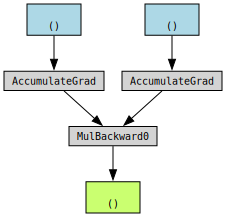

In [9]:
from torchviz import make_dot

make_dot(y)

# PyTorch autograd on a simple scenario

## Sanity Check:

In [10]:
U = torch.tensor([[1., 2.]], requires_grad=True)
V = torch.tensor([[3., 4.], [5., 6.]], requires_grad=True)
W = torch.matmul(U, V)
f = W.sum()
f.backward()
print(U.grad)
print(V.grad)

tensor([[ 7., 11.]])
tensor([[1., 1.],
        [2., 2.]])


![title](https://bea.stollnitz.com/images/fashion-pytorch/2-simple-dag.png)

### Comparing against the Math:

$U = \begin{bmatrix}u_{1}& u_{2}\end{bmatrix}$
$V = \begin{bmatrix}v_{11}& v_{12}\\
v_{21}& v_{22}\end{bmatrix}$

Where, $u_{1} = 1, u_{2} = 2, v_{11} = 3, v_{12} = 4, v_{21} = 5, v_{22} = 6$

<br>

$f$ = sum($UV$)    
= sum($\begin{bmatrix}u_{1}& u_{2}\end{bmatrix}$ $\begin{bmatrix}v_{11}& v_{12}\\
v_{21}& v_{22}\end{bmatrix}$)    
= sum($\begin{bmatrix}u_{1}v_{11} + u_{2}v_{21}& u_{1}v_{12} + u_{2}v_{22}\end{bmatrix}$)
= $u_{1}v_{11} + u_{2}v_{21} + u_{1}v_{12} + u_{2}v_{22}$

The derivates of $f$ wrt $U$ and $V$ are:

$\frac{\partial f}{\partial U}$ = [$ \frac{\partial f}{\partial u_{1}}$ $\frac{\partial f}{\partial u_{2}}$] = $\begin{bmatrix}v_{11} + v_{12} & v_{21} + v_{22}\end{bmatrix}$ = $\begin{bmatrix}7 & 11\end{bmatrix}$

$\frac{\partial f}{\partial V}$ = $\begin{bmatrix} \frac{\partial f}{\partial v_{11}} & \frac{\partial f}{\partial v_{12}}\\ \\
 \frac{\partial f}{\partial v_{21}} & \frac{\partial f}{\partial v_{22}}\end{bmatrix}$

= $\begin{bmatrix}u_{1} & u_{1}\\ 
u_{2} & u_{2}\end{bmatrix}$ = $\begin{bmatrix}1 & 1\\
2 & 2\end{bmatrix}$


## For Linear Regression

In [11]:
W = torch.tensor([[1., 2.]], requires_grad=True)
X = torch.tensor([[3.], [4.]])
b = torch.tensor([5.], requires_grad=True)
y = torch.tensor([[6.]])
y_prime = torch.matmul(W, X) + b
loss_fn = torch.nn.MSELoss()
loss = loss_fn(y_prime, y)
loss.backward()
print(W.grad)
print(b.grad)

# Analytical gradient
dloss_dy_prime = 2*(y_prime - y)
dy_prime_dW = X
dloss_dW = torch.matmul(dloss_dy_prime, dy_prime_dW.t())
dloss_db = dloss_dy_prime
print(dloss_dW)
print(dloss_db)

tensor([[60., 80.]])
tensor([20.])
tensor([[60., 80.]], grad_fn=<MmBackward0>)
tensor([[20.]], grad_fn=<MulBackward0>)


You would not always require pytorch to keep tarck of the gradients. For example: While testing your model, you do not require the gradients. You can turn off the gradients by using the `torch.no_grad()` context manager.

In [12]:
U = torch.tensor([[1., 2.]], requires_grad=True)
V = torch.tensor([[3., 4.], [5., 6.]], requires_grad=True)
W = torch.matmul(U, V)
print(W.requires_grad)

with torch.no_grad():
  W = torch.matmul(U, V)
print(W.requires_grad)

True
False


PyTorch DAGs are dynamic. This means that after each forward and backward pass, we’re free to change the structure of the graph and the shape of the tensors that flow through it, because the graph will be re-created in the next pass. This is a very powerful feature that allows tremendous flexiblity when training a model.



Back to the graph:

![title](https://blog.paperspace.com/content/images/2019/03/full_graph.png)

In [13]:
import torch 

a = torch.randn((3,3), requires_grad = True)

w1 = torch.randn((3,3), requires_grad = True)
w2 = torch.randn((3,3), requires_grad = True)
w3 = torch.randn((3,3), requires_grad = True)
w4 = torch.randn((3,3), requires_grad = True)

b = w1*a 
c = w2*a

d = w3*b + w4*c 

L = (10 - d).sum()

print("The grad fn for a is", a.grad_fn)
print("The grad fn for d is", d.grad_fn)
print()

print("Gradient at a (before .backward()) is", a.grad)
print("Gradient at w1 (before .backward()) is", w1.grad)
print()

L.backward()

print("Gradient at a (after .backward()) is", a.grad)
print("Gradient at w1 (after .backward()) is", w1.grad)
print()

# gradient at d (non-leaf node) is None
print("Gradient at d (after .backward()) is", d.grad)


The grad fn for a is None
The grad fn for d is <AddBackward0 object at 0x114c47910>

Gradient at a (before .backward()) is None
Gradient at w1 (before .backward()) is None

Gradient at a (after .backward()) is tensor([[ 0.2079, -0.4495,  2.2874],
        [-4.6481,  0.4453,  0.8300],
        [-0.3831,  1.1495, -0.2250]])
Gradient at w1 (after .backward()) is tensor([[-0.0107,  0.0962,  0.0334],
        [ 0.7649, -2.4350,  0.0403],
        [-0.0100,  0.5487, -1.1644]])

Gradient at d (after .backward()) is None


/var/folders/8m/_7tr45rs7cv09g0b7cyt4t8w0000gn/T/ipykernel_2063/2485809194.py:32: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print("Gradient at d (after .backward()) is", d.grad)


- The leaves don’t have grad_fn but will have gradients. 
- Non-leaf nodes have grad_fn but don’t have gradients. 
- Before the backward() is called there are no grad values.

---

# Defining Neural Networks in Pytorch

## nn.Linear

The Linear module does a linear transformation with a bias. It takes the input and output dimensions as parameters, and creates the weights in the object.

In [14]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
# applys a linear transformation to the data
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transformed', transformed.shape)
print()
print('Weights:\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([2, 3])
transformed torch.Size([2, 4])

Weights:

W: Parameter containing:
tensor([[ 0.1454,  0.1060, -0.1141],
        [-0.3195, -0.2606, -0.3758],
        [ 0.5148,  0.5474, -0.2281],
        [-0.1850,  0.5766,  0.5603]], requires_grad=True)
b: Parameter containing:
tensor([-0.0693,  0.4642, -0.1466,  0.3585], requires_grad=True)


The weights in nn.Linear are randomly initialized. If we want to set the weights, we can do so by accessing the weight attribute of the Linear object.

In [15]:
# To set the weights and bias
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out) # in this case, the weights are randomly initialized
linear_module.weight = nn.Parameter(torch.ones(d_out, d_in)) # nn.Parameter, assigns the tensor to the module's parameters
linear_module.bias = nn.Parameter(torch.zeros(d_out))

transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transformed', transformed.shape)
print()
print('Weights:\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([2, 3])
transformed torch.Size([2, 4])

Weights:

W: Parameter containing:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
b: Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)


## nn.Sequential

nn.linear just gives us one single linear transformation (one layer). How to define a multi-layer network? - By using the nn.Sequential module.

Used when you want to create a block of layers

In [16]:
d_in = 3
d_hidden = 4
d_out = 1
sequential_module = nn.Sequential(
                nn.Linear(d_in, d_out),
                nn.Linear(d_out, d_out),
            )
print(f'sequential_module: {sequential_module}')

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
transformed = sequential_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transformed', transformed.shape)
print()
print('Weights:\n')
for idx, layer in enumerate(sequential_module):
    if type(layer) == nn.Linear:
        print(f'Layer {idx} is a Linear Layer')
        print(f'W: {layer.weight}')
        print(f'b: {layer.bias}')
        print()

sequential_module: Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
  (1): Linear(in_features=1, out_features=1, bias=True)
)
example_tensor torch.Size([2, 3])
transformed torch.Size([2, 1])

Weights:

Layer 0 is a Linear Layer
W: Parameter containing:
tensor([[-0.1788, -0.4794,  0.3454]], requires_grad=True)
b: Parameter containing:
tensor([0.4984], requires_grad=True)

Layer 1 is a Linear Layer
W: Parameter containing:
tensor([[-0.4026]], requires_grad=True)
b: Parameter containing:
tensor([-0.2113], requires_grad=True)



you can access the layers of the model by indexing the model object.

In [17]:
layer_1 = sequential_module[0]
print('Layer 1', layer_1)
print('W:', layer_1.weight)
print('b:', layer_1.bias)

Layer 1 Linear(in_features=3, out_features=1, bias=True)
W: Parameter containing:
tensor([[-0.1788, -0.4794,  0.3454]], requires_grad=True)
b: Parameter containing:
tensor([0.4984], requires_grad=True)


Can also access the parameters of the model by using the parameters() method.

In [18]:
params = sequential_module.parameters()
for param in params:
    print(param)

Parameter containing:
tensor([[-0.1788, -0.4794,  0.3454]], requires_grad=True)
Parameter containing:
tensor([0.4984], requires_grad=True)
Parameter containing:
tensor([[-0.4026]], requires_grad=True)
Parameter containing:
tensor([-0.2113], requires_grad=True)


## nn.Module

What if you need to modify how the network works in the forward path? - You can define your own custom module by subclassing the nn.Module class and implementing the forward method.

nn.Sequential is great at making chains, but when you need more flexibility and control, you can define your own module.

Modules are implemented as subclasses of the torch.nn.Module class. All modules are callable and can be composed together to create complex functions. 

Note: most of the functionality implemented for modules can be accessed in a functional form via torch.nn.functional, but these require you to create and manage the weight tensors yourself.


In [19]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # Call the constructor of the parent class nn.Module to perform
        # the necessary initialization
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.hidden = nn.Linear(self.input_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size, bias=False)
        self.relu = nn.ReLU()

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input X
    def forward(self, X):
        return self.out(self.relu(self.hidden(X)))

In [20]:
X = torch.tensor([[1.,2,3], 
                [4,5,6]])
X = X.flatten()
print(X)
model = MLP(6, 4, 1)
print(model)

output = model(X)
print(output)
print(output.shape)

tensor([1., 2., 3., 4., 5., 6.])
MLP(
  (hidden): Linear(in_features=6, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=False)
  (relu): ReLU()
)
tensor([3.0610], grad_fn=<SqueezeBackward4>)
torch.Size([1])


Define a model class via nn.Module comes in handy when you want to modify how the network works in the forward path. For example, you might want to add a new layer, or change the order of the layers, combine outputs from different layers, etc.

In [21]:
class MLPtwo(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.hidden_first_half = nn.Linear(self.input_size, self.hidden_size)
        self.hidden_second_half = nn.Linear(self.input_size, self.hidden_size)

        # self.hidden_size * 2 because we are concatenating the outputs
        self.out = nn.Linear(self.hidden_size * 2, self.output_size, bias=False)
        self.relu = nn.ReLU()

    def forward(self, X1, X2):
        # Just an arbitrary example of how the forward pass can be modified
        output1 = self.hidden_first_half(X1)
        output2 = self.hidden_second_half(X2)
        output = torch.cat((output1, output2))
        output = self.out(self.relu(output))
        return output


In [22]:
X = torch.tensor([[1.,2,3], 
                [4,5,6]])
print(X.shape)
model = MLPtwo(3, 4, 1)
print(model)

output = model(X[0], X[1])
print(output)
print(output.shape)

torch.Size([2, 3])
MLPtwo(
  (hidden_first_half): Linear(in_features=3, out_features=4, bias=True)
  (hidden_second_half): Linear(in_features=3, out_features=4, bias=True)
  (out): Linear(in_features=8, out_features=1, bias=False)
  (relu): ReLU()
)
tensor([0.0238], grad_fn=<SqueezeBackward4>)
torch.Size([1])


More building blocks:
- nn.ModuleList
- nn.ModuleDict

## nn.ModuleDict

In [23]:
class LinearNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(LinearNet, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleDict(
            {
                "layer1": nn.Linear(input_size, layers_size),
                "act_1": nn.ReLU(),
                "layer2": nn.Linear(layers_size, output_size),
                "act_2": nn.Sigmoid(),
            }
        )

    def forward(self, x):
        x = self.layers["layer1"](x)
        x = self.layers["act_1"](x)
        x = self.layers["layer2"](x)
        x = self.layers["act_2"](x)
        return x

In [24]:
net = LinearNet(3, 4, 5, 1)
print(net)

X = torch.tensor([[1.,2,3]])
output = net(X)
print('output:', output)

params = list(net.parameters())
print(params)

LinearNet(
  (layers): ModuleDict(
    (layer1): Linear(in_features=3, out_features=5, bias=True)
    (act_1): ReLU()
    (layer2): Linear(in_features=5, out_features=1, bias=True)
    (act_2): Sigmoid()
  )
)
output: tensor([[0.4012]], grad_fn=<SigmoidBackward0>)
[Parameter containing:
tensor([[-0.3563,  0.5485,  0.5347],
        [-0.3942, -0.3392,  0.3530],
        [-0.3233, -0.2097, -0.1885],
        [ 0.0126,  0.0794,  0.1731],
        [-0.5383,  0.4156,  0.3053]], requires_grad=True), Parameter containing:
tensor([-0.0627,  0.5047,  0.1679,  0.4138,  0.0964], requires_grad=True), Parameter containing:
tensor([[-0.1439,  0.1444, -0.2606, -0.2789,  0.4163]], requires_grad=True), Parameter containing:
tensor([-0.3782], requires_grad=True)]


## nn.ModuleList

Just like a python list, it was designed to store any desired number of nn.Module objects. 

In [25]:
class LinearNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(LinearNet, self).__init__()
        self.num_layers = num_layers
        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size)])
        self.linears.extend([nn.Linear(layers_size, layers_size) for i in range(1, self.num_layers-1)])
        self.linears.append(nn.Linear(layers_size, output_size))

    def forward(self, x):
        for layer in self.linears:
            x = layer(x)
        return x

In [26]:
net = LinearNet(3, 4, 5, 1)
print(net)

X = torch.tensor([[1.,2,3]])
output = net(X)
print('output:', output)

params = list(net.parameters())
print(params)

LinearNet(
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1-2): 2 x Linear(in_features=5, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=1, bias=True)
  )
)
output: tensor([[0.8598]], grad_fn=<AddmmBackward0>)
[Parameter containing:
tensor([[ 0.2281,  0.2223, -0.2298],
        [ 0.2409, -0.4355, -0.5672],
        [-0.0480, -0.0210,  0.0961],
        [-0.0975,  0.2715,  0.3498],
        [ 0.5225, -0.5211,  0.1602]], requires_grad=True), Parameter containing:
tensor([ 0.0139,  0.2474,  0.0764,  0.1238, -0.3821], requires_grad=True), Parameter containing:
tensor([[ 0.3991,  0.3697, -0.2010,  0.1910, -0.4330],
        [-0.3950,  0.3821,  0.4307, -0.4103, -0.3291],
        [ 0.0450, -0.2583,  0.0460, -0.2855,  0.0067],
        [-0.1104, -0.2707, -0.1204,  0.1519, -0.2983],
        [-0.4120,  0.4074,  0.2806,  0.0661,  0.3353]], requires_grad=True), Parameter containing:
tensor([-0.3276, -0.4383,  0.1940,  0.2997, -0.0826], req

Pitfall:

What happens if you just use a python list? - The parameters of the modules in the list won't be registered as parameters of the model.

In [27]:
class LinearNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(LinearNet, self).__init__()
        self.num_layers = num_layers
        self.linears = [nn.Linear(input_size, layers_size)] # nn.ModuleList() is not used
        self.linears.extend([nn.Linear(layers_size, layers_size) for i in range(1, self.num_layers-1)])
        self.linears.append(nn.Linear(layers_size, output_size))

    def forward(self, x):
        for layer in self.linears:
            x = layer(x)
        return x


In [28]:
net = LinearNet(3, 4, 5, 1)
print(net)

X = torch.tensor([[1.,2,3]])
output = net(X)
print('output:', output)

params = list(net.parameters())
print(params)

LinearNet()
output: tensor([[-0.0222]], grad_fn=<AddmmBackward0>)
[]


You would still get an output, but the parameters of the modules in the list won't be registered as parameters of the model. This means while training, the weights of the modules in the list won't be updated.

## Activation Functions

PyTorch implements a number of activation functions including but not limited to ReLU, Tanh, and Sigmoid. Since they are modules, they need to be instantiated.

In [29]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


## Decision Boundaries of Different Activation Functions:

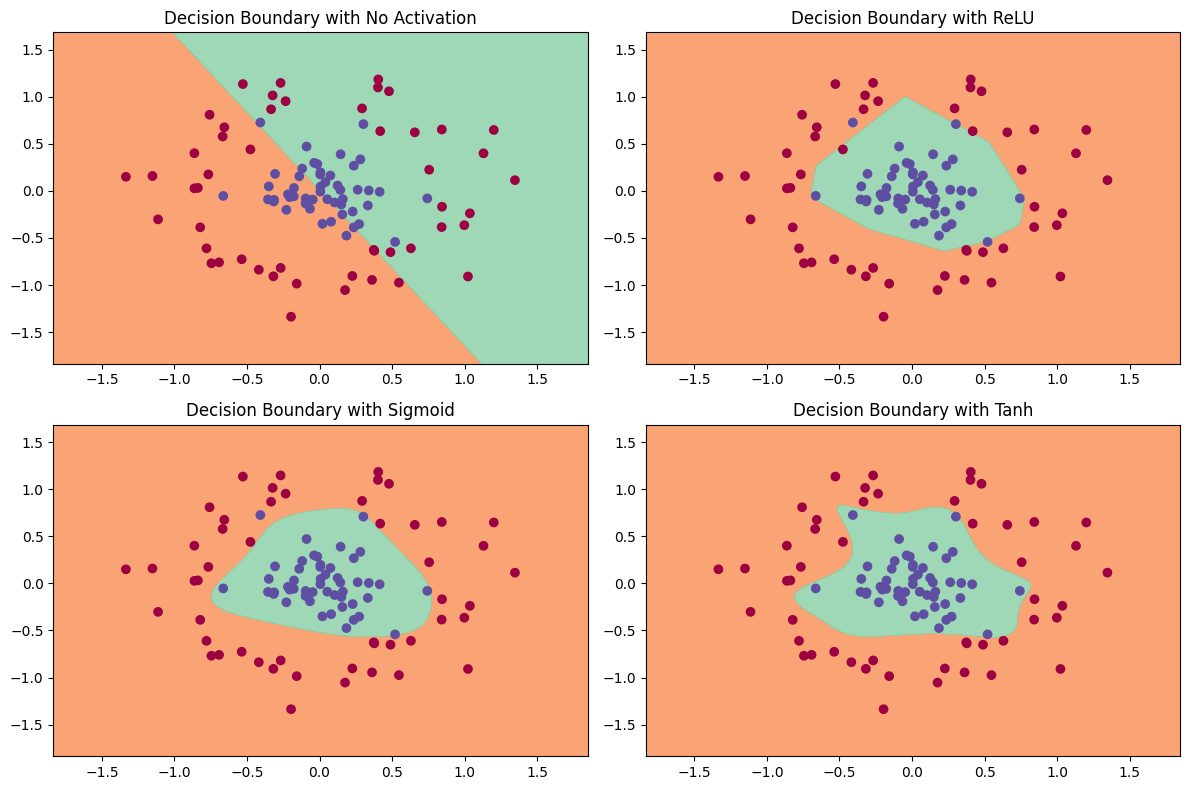

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons, make_circles
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

# Generate synthetic data
X, y = make_circles(n_samples=100, noise=0.2, factor=0.2, random_state=42)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).unsqueeze(1).float()

### More on this later ###
# Function to train the model
def train_model(model, X, y):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    epochs = 1000

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    return model
### More on this later ###


# Function to plot decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    with torch.no_grad():
        pred = model(grid).reshape(xx.shape)
        pred = torch.sigmoid(pred) # Apply sigmoid to get probabilities

    plt.contourf(xx, yy, pred, levels=[0, 0.5, 1], cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y[:, 0], cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


class NeuralNetwork(nn.Module):
    def __init__(self, activation_func):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 10)
        if activation_func:
            self.activation = activation_func()
        else:
            self.activation = None
        self.layer2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.layer1(x)
        if self.activation:
            x = self.activation(x)
        x = self.layer2(x)
        return x

# List of activation functions
# activation_functions = [None, nn.ReLU, nn.Sigmoid, nn.Tanh, nn.SiLU, nn.Hardswish]
activation_functions = [None, nn.ReLU, nn.Sigmoid, nn.Tanh]

# Determine the number of rows and columns for the subplot grid
num_functions = len(activation_functions)
num_columns = 2
num_rows = (num_functions + 1) // num_columns  # Add 1 to handle odd number of functions

# Train models with different activations and plot their decision boundaries
plt.figure(figsize=(12, num_rows * 4))

for i, activation_func in enumerate(activation_functions):
    # Update the NeuralNetwork class to handle None as no activation
    if activation_func is None:
        activation_name = "No Activation"
        activation_func = nn.Identity  # Using Identity for no activation
    else:
        activation_name = activation_func.__name__

    # Instantiate and train the model
    model = NeuralNetwork(activation_func)
    trained_model = train_model(model, X, y)

    # Plot decision boundary
    plt.subplot(num_rows, num_columns, i + 1)
    plot_decision_boundary(trained_model, X, y)
    plt.title(f'Decision Boundary with {activation_name}')

plt.tight_layout()
plt.show()

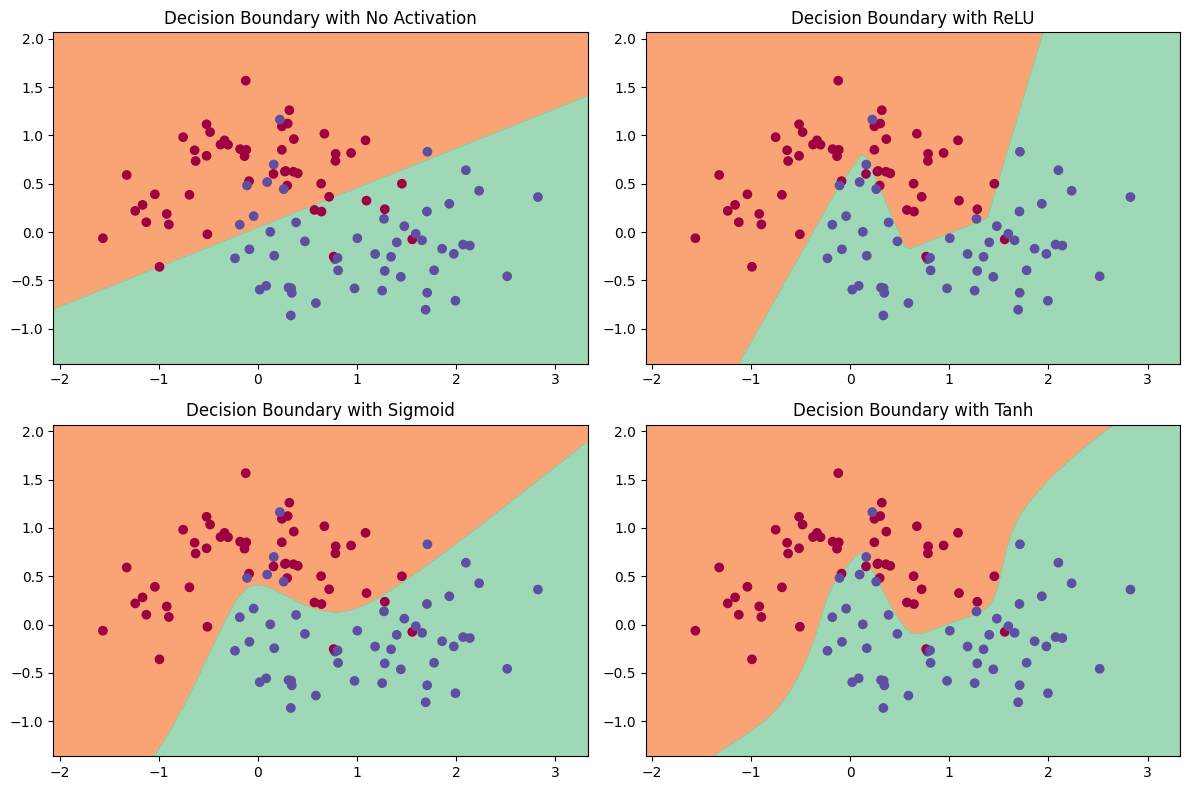

In [31]:
torch.manual_seed(42)
# Generate synthetic data
X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).unsqueeze(1).float()

activation_functions = [None, nn.ReLU, nn.Sigmoid, nn.Tanh]

# Determine the number of rows and columns for the subplot grid
num_functions = len(activation_functions)
num_columns = 2
num_rows = (num_functions + 1) // num_columns  # Add 1 to handle odd number of functions

# Train models with different activations and plot their decision boundaries
plt.figure(figsize=(12, num_rows * 4))

for i, activation_func in enumerate(activation_functions):
    # Update the NeuralNetwork class to handle None as no activation
    if activation_func is None:
        activation_name = "No Activation"
        activation_func = nn.Identity  # Using Identity for no activation
    else:
        activation_name = activation_func.__name__

    # Instantiate and train the model
    model = NeuralNetwork(activation_func)
    trained_model = train_model(model, X, y)

    # Plot decision boundary
    plt.subplot(num_rows, num_columns, i + 1)
    plot_decision_boundary(trained_model, X, y)
    plt.title(f'Decision Boundary with {activation_name}')

plt.tight_layout()
plt.show()

### What happens when you add more layers to a neural network? 

- The network becomes more expressive. It can learn more complex functions.
- That isn't necessarily a good thing. Taking a look below, the network does not learn to map the underlying data distribution. It just learns to map the data it has seen, which is not the same thing.

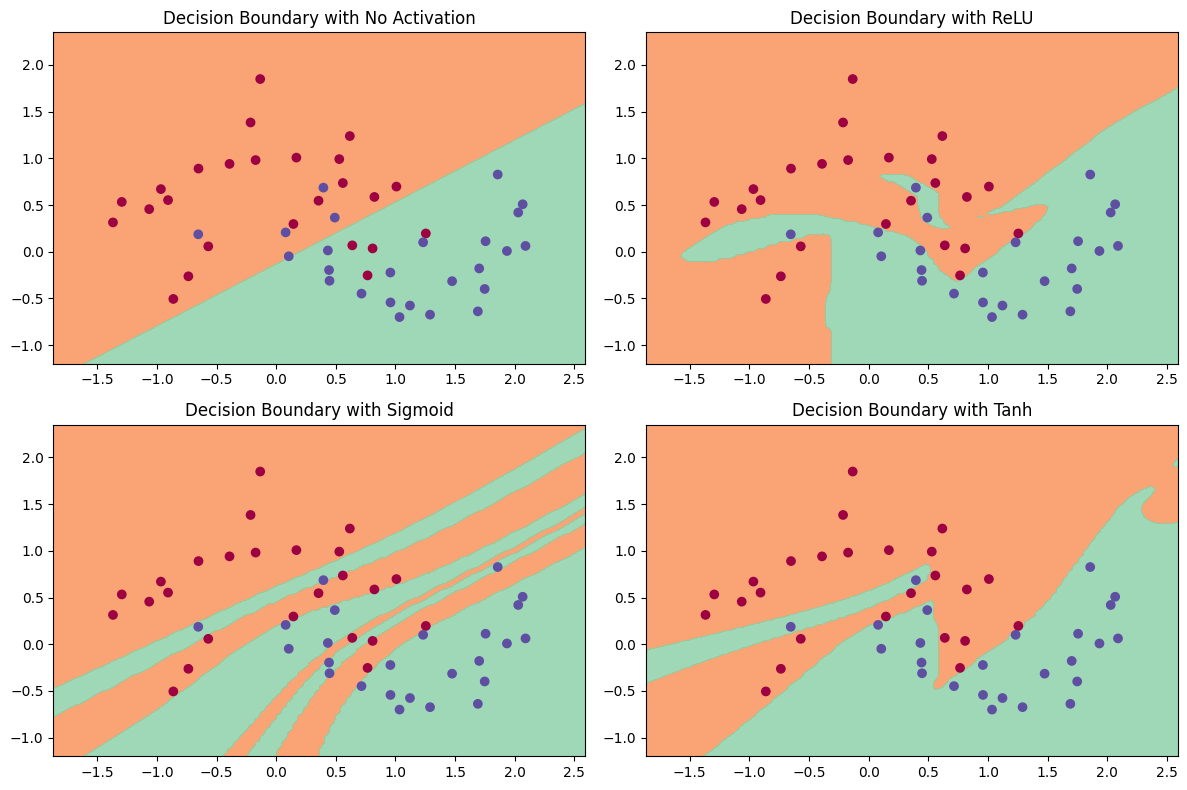

In [32]:
torch.manual_seed(42)
class DeepNeuralNetwork(nn.Module):
    def __init__(self, activation_func):
        super(DeepNeuralNetwork, self).__init__()
        if activation_func:
            self.activation = activation_func()
        else:
            self.activation = None
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            self.activation,
            nn.Linear(10, 64),
            self.activation,
            nn.Linear(64, 128),
            self.activation,
            nn.Linear(128, 256),
            self.activation,
            nn.Linear(256, 512),
            self.activation,
            nn.Linear(512, 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Generate synthetic data
# X, y = make_circles(n_samples=300, noise=0.3, factor=0.1, random_state=42)
X, y = make_moons(n_samples=50, noise=0.3, random_state=42)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).unsqueeze(1).float()

activation_functions = [None, nn.ReLU, nn.Sigmoid, nn.Tanh]

# Determine the number of rows and columns for the subplot grid
num_functions = len(activation_functions)
num_columns = 2
num_rows = (num_functions + 1) // num_columns  # Add 1 to handle odd number of functions

# Train models with different activations and plot their decision boundaries
plt.figure(figsize=(12, num_rows * 4))

for i, activation_func in enumerate(activation_functions):
    if activation_func is None:
        activation_name = "No Activation"
        activation_func = nn.Identity  # Using Identity for no activation
    else:
        activation_name = activation_func.__name__

    # Instantiate and train the model
    model = DeepNeuralNetwork(activation_func)
    trained_model = train_model(model, X, y)

    # Plot decision boundary
    plt.subplot(num_rows, num_columns, i + 1)
    plot_decision_boundary(trained_model, X, y)
    plt.title(f'Decision Boundary with {activation_name}')

plt.tight_layout()
plt.show()

### References
https://towardsdatascience.com/computational-graphs-in-pytorch-and-tensorflow-c25cc40bdcd1    
https://courses.cs.washington.edu/courses/cse446/19au/section9.html    
https://www.python-engineer.com/courses/pytorchbeginner/03-autograd/     
https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf    
https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/    